In [1]:
!apt-get install default-jre
!java -version
!pip install h2o


Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [2]:
import pandas as pd
import numpy as np 
import spacy 
import unicodedata

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import re
from textblob import TextBlob

from wordcloud import WordCloud 
import matplotlib.pyplot as plt 
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

import h2o
from h2o.automl import H2OAutoML
h2o.init()



Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvz2kvryy
  JVM stdout: /tmp/tmpvz2kvryy/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvz2kvryy/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,1 month and 7 days
H2O_cluster_name:,H2O_from_python_unknownUser_6dkqy6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Loading Data

In [4]:
data = pd.read_excel('/content/drive/MyDrive/DataSets/QLC /Data1.xlsx')
data = data.dropna()
data.head()

,Unnamed: 0,OpportunityId,OpportunityStageName,ActivityDescription
0,0,0006255A-A476-4DEF-9C67-0E4B0A83ACD0,Closed Won,"#ProformaInvoice\r\nDear Sir,\r\n\r\nThanks fo..."
1,1,0006255A-A476-4DEF-9C67-0E4B0A83ACD0,Closed Won,"#Emailed\r\nDear Sir,\r\n\r\nPlease find revis..."
2,2,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ..."
3,3,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ..."
4,4,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,#Follow up\r\n\r\nCalled on landline number\r\...


Converting DF to Dictionary

In [5]:
#convert to dictionary
cov_dic = {'OpportunityId': str,
           'OpportunityStageName': str,
           'ActivityDescription': str}
df= data.astype(cov_dic)
df=df.drop(columns=['Unnamed: 0'])
df.head()

,OpportunityId,OpportunityStageName,ActivityDescription
0,0006255A-A476-4DEF-9C67-0E4B0A83ACD0,Closed Won,"#ProformaInvoice\r\nDear Sir,\r\n\r\nThanks fo..."
1,0006255A-A476-4DEF-9C67-0E4B0A83ACD0,Closed Won,"#Emailed\r\nDear Sir,\r\n\r\nPlease find revis..."
2,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ..."
3,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,"#Proposal\r\n\r\nDear Ma'am,\r\n\r\nGreetings ..."
4,000992B7-C04E-464A-A010-A2F3F9DCEF8B,Proposal,#Follow up\r\n\r\nCalled on landline number\r\...


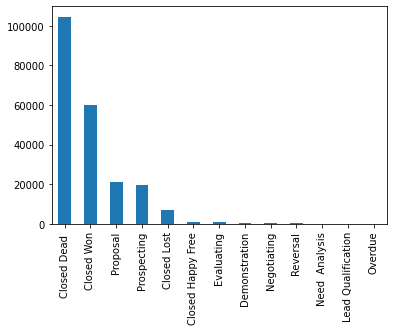

In [6]:
df['OpportunityStageName'].value_counts().plot(kind='bar')

In [7]:
#removing '-' in id
df['OpportunityId'] = df['OpportunityId'].apply(lambda x: str(x).replace('-', ''))

#Concatanating Conversations of each OpportunityID
df = df.groupby(['OpportunityId', 'OpportunityStageName'], as_index = False).agg({'ActivityDescription': ' '.join})
#upper Case
df['upper_count'] = df['ActivityDescription'].apply(lambda x: len([t for t in x.split() if t.isupper()]))

# Lower case
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x:str(x).lower())

#removing accented Chars
def remove_accented_chars(x):
  x= unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8','ignore')
  return x
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: remove_accented_chars(x))

#removing '/r' and '/n
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: str(x).replace('\r', ' '))
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: str(x).replace('\r\n', ' '))
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: str(x).replace('\n', ' '))

#count and remove URLS
df['URLs_count'] = df['ActivityDescription'].apply(lambda x: len(re.findall(r'(http|https|ftp|ssh|www)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^+%&/~+#-])?',str(x))))
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: re.sub(r'(http|https|ftp|ssh|www)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^+%&/~+#-])?','',str(x)))
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: re.sub('(?:\s)www[^, ]*', '', str(x)))

#remove single letters
df['ActivityDescription'] = df.ActivityDescription.str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
# remove all numbers
df['ActivityDescription'] = df.ActivityDescription.str.replace('\d+', '')

df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: re.sub(r'[^\w ]+',"",x)) #removing special characters
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: ' '.join(x.split())) #removing double spaces

#counting hashtags
df['hash_count'] = df['ActivityDescription'].apply(lambda x : re.findall(r'(#[Aa])', x))
df['hash_count'] =df['hash_count'].apply(lambda x : len(x))

#count email
df['e_count'] = df['ActivityDescription'].apply(lambda x : re.findall(r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\\.[a-zA-Z0-9-.]+",x))
df['e_count'] = df['e_count'].apply(lambda x:len(x))
#remove email 
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x: re.sub("[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\\.[a-zA-Z0-9-.]+","",str(x)))

#stop word count
df['sw_count']= df['ActivityDescription'].apply(lambda x: len([t for t in x.split() if t in stopwords]))
# removing stop words
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x : ' '.join([t for t in x.split() if t not in stopwords]))

In [8]:
df['URLs_count'].value_counts()

0     17106
2       405
4       301
1       207
3       207
6        51
8        44
5        13
12       13
9         5
10        5
16        5
24        3
7         3
21        2
15        2
40        1
14        1
36        1
11        1
18        1
28        1
Name: URLs_count, dtype: int64

In [9]:
#removing top 20 frequet words
text = ' '.join(df['ActivityDescription'])
text = text.split()
freq_comm = pd.Series(text).value_counts()
f20 = freq_comm[:20]
f20

df['ActivityDescription']= df['ActivityDescription'].apply(lambda x : ' '.join([t for t in x.split() if t not in f20]))


In [10]:
#Label encoding target variable
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['OpportunityStageName']= label_encoder.fit_transform(df['OpportunityStageName']) 

In [11]:
#tokenization
from nltk.tokenize import sent_tokenize, word_tokenize 
#df['ActivityDescription']= df['ActivityDescription'].apply(lambda x: [word for word in word_tokenize(x)])
#word_tokenize(text)
df['ActivityDescription']= df['ActivityDescription'].apply(word_tokenize)

In [12]:
stemmer = nltk.stem.SnowballStemmer('english')
def tokenize(text):
   tokens = text
   stems = [stemmer.stem(item) for item in tokens if (item not in stopwords)]
   return stems

In [13]:
df['ActivityDescription'] = df['ActivityDescription'].apply(lambda x : tokenize(x))

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df, test_size=0.2, random_state=111)

In [15]:
'''from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=10000, lowercase=False, ngram_range=(1,2))
train_vectors = vectorizer_tf.fit_transform(X_train.ActivityDescription)'''

'from sklearn.feature_extraction.text import TfidfVectorizer\nvectorizer_tf = TfidfVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=10000, lowercase=False, ngram_range=(1,2))\ntrain_vectors = vectorizer_tf.fit_transform(X_train.ActivityDescription)'

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_tf = CountVectorizer(tokenizer=tokenize, stop_words=None, max_df=0.75, max_features=10000, lowercase=False, ngram_range=(1,1))
train_vectors = vectorizer_tf.fit_transform(X_train.ActivityDescription)


In [17]:
test_vectors = vectorizer_tf.transform(X_test.ActivityDescription)

In [18]:
train_vectors

<14702x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 804872 stored elements in Compressed Sparse Row format>

In [19]:
vectorizer_tf.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=False, max_df=0.75, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenize at 0x7f9a83567320>,
                vocabulary=None)>

In [20]:
X_train.head()

,OpportunityId,OpportunityStageName,ActivityDescription,upper_count,URLs_count,hash_count,e_count,sw_count
6585,5B1EEBF59D1F4E3CAAE341446232D9AE,0,"[requir, bulkmail, solut, databas, databas, ar...",0,0,0,0,18
15223,D3E33DD3981849FBA6899BE3B32C421F,0,"[mrpadmanabhan, outset, thank, interest, postm...",14,0,0,0,155
12751,B06F8B9BAEF9415884100EB11DE0B542,0,"[given, md, identifi, evalu, soon, test, batte...",2,0,0,0,212
8380,746649B53E9C468D97402FFB19AD07A3,3,"[spoke, madam, releas, sister, concern, com, f...",0,0,0,0,13
18320,FF34E8FD4C8F43F9A132D1DD1E28A4A2,3,"[emails, rashmi, inform, confirm, meet, pm, da...",21,0,0,0,729


In [21]:
train_df=pd.DataFrame(train_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
train_df=pd.concat([train_df,X_train['OpportunityStageName'].reset_index(drop=True)], axis=1)
train_df=pd.concat([train_df,X_train[['upper_count','hash_count','e_count','sw_count']].reset_index(drop=True)], axis=1)
train_df

,__,___,______________________________________________,_________________________________________________,________________________________________________________,__________________________________________________________,________________________________________________________________,_________________________________________________________________,_____________________________________________________________________,_______________________________________________________________________,________________________________________________________________________,________________________________________________________________________________,__________________________________________________________________________________,___________________________________________________________________________________,_____________________________________________________________________________________,_______________________________________________________________________________________,________________________________________________________________________________________,__________________________________________________________________________________________,__dtaj,_ask,_fs,_had,_inform,_spoke,aa,aaacqn,aaacqnzg,aabcsk,aabcskzv,aacaccountsganeshgroupin,aaccnj,aaccnjz,aacedpganeshgroupin,aaecnrz,aakash,aakashpressfitindiacom,aamir,aanad,aanand,aanchal,...,youav,youll,young,youra,youth,youtub,youu,youv,yr,yrs,ys,yugandhar,yujeeta,yukthi,yukti,yuou,yusuf,yuvraj,zafar,zaptech,zaveri,zenith,zero,zilla,zimbera,zimbra,zing,zip,zoho,zohodesk,zonal,zone,zoom,zosh,zune,OpportunityStageName,upper_count,hash_count,e_count,sw_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,155
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,212
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,13
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,21,0,0,729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14697,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,12,0,0,16
14698,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,0,164
14699,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,14,0,0,212
14700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,84,0,0,268


In [22]:
test_df=pd.DataFrame(test_vectors.toarray(), columns=vectorizer_tf.get_feature_names())
test_df=pd.concat([test_df,X_test['OpportunityStageName'].reset_index(drop=True)], axis=1)
test_df=pd.concat([test_df,X_test[['upper_count','hash_count','e_count','sw_count']].reset_index(drop=True)], axis=1)
test_df

,__,___,______________________________________________,_________________________________________________,________________________________________________________,__________________________________________________________,________________________________________________________________,_________________________________________________________________,_____________________________________________________________________,_______________________________________________________________________,________________________________________________________________________,________________________________________________________________________________,__________________________________________________________________________________,___________________________________________________________________________________,_____________________________________________________________________________________,_______________________________________________________________________________________,________________________________________________________________________________________,__________________________________________________________________________________________,__dtaj,_ask,_fs,_had,_inform,_spoke,aa,aaacqn,aaacqnzg,aabcsk,aabcskzv,aacaccountsganeshgroupin,aaccnj,aaccnjz,aacedpganeshgroupin,aaecnrz,aakash,aakashpressfitindiacom,aamir,aanad,aanand,aanchal,...,youav,youll,young,youra,youth,youtub,youu,youv,yr,yrs,ys,yugandhar,yujeeta,yukthi,yukti,yuou,yusuf,yuvraj,zafar,zaptech,zaveri,zenith,zero,zilla,zimbera,zimbra,zing,zip,zoho,zohodesk,zonal,zone,zoom,zosh,zune,OpportunityStageName,upper_count,hash_count,e_count,sw_count
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,33
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,45
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,5,0,0,187
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,19
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,18,0,0,168
3673,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,20,0,0,121
3674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,1,0,0,17


## Implementing H2o for model selection

In [23]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
h2o_train_df.types

{'__': 'int',
 '___': 'int',
 '______________________________________________': 'int',
 '_________________________________________________': 'int',
 '________________________________________________________': 'int',
 '__________________________________________________________': 'int',
 '________________________________________________________________': 'int',
 '_________________________________________________________________': 'int',
 '_____________________________________________________________________': 'int',
 '_______________________________________________________________________': 'int',
 '________________________________________________________________________': 'int',
 '________________________________________________________________________________': 'int',
 '__________________________________________________________________________________': 'int',
 '___________________________________________________________________________________': 'int',
 '______________________________

In [25]:
h2o_train_df['OpportunityStageName'] = h2o_train_df['OpportunityStageName'].asfactor()
h2o_test_df['OpportunityStageName'] = h2o_test_df['OpportunityStageName'].asfactor()

In [26]:
aml = H2OAutoML(max_models = 5, seed = 10,exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, balance_classes=True, max_after_balance_size=0.3)


here i have set it to use top 10 models



In [27]:
x=vectorizer_tf.get_feature_names()
y='OpportunityStageName'

In [28]:
aml.train(x = x, y = y, training_frame = h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
04:47:27.603: Project: AutoML_20210309_44727598
04:47:27.606: Cross-validation disabled by user: no fold column nor nfolds > 1.
04:47:27.621: Setting stopping tolerance adaptively based on the training frame: 0.008247299966690887
04:47:27.621: Build control seed: 10
04:47:27.621: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
04:48:16.797: training frame: Frame key: automl_training_py_1_sid_933c    cols: 10005    rows: 13210  chunks: 71    size: 59342333  checksum: -774770350816800
04:48:16.857: validation frame: Frame key: py_2_sid_933c    cols: 10005    rows: 3676  chunks: 18    size: 15111743  checksum: -300078056700000
04:48:21.922: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_933c    cols: 10005    rows: 1492  chunks: 71    size: 56934656  checksum: -24924705112800
04:48:21.922: blending frame: NULL
04:48:21.922: response column:

Works best with XGBoost 

In [29]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_3_AutoML_20210309_044727,0.522145,0.68325,0.447526,0.200279,nan,nan
XGBoost_1_AutoML_20210309_044727,0.554987,0.70511,0.448929,0.201537,nan,nan
XGBoost_2_AutoML_20210309_044727,0.556193,0.728894,0.450662,0.203097,nan,nan
DRF_1_AutoML_20210309_044727,0.630527,0.841606,0.50829,0.258359,nan,nan
GLM_1_AutoML_20210309_044727,0.631151,1.02101,0.53349,0.284612,nan,nan


In [30]:
pred=aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [31]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.18363075224519704
RMSE: 0.4285215890071316
LogLoss: 0.6322413890024305
Mean Per-Class Error: 0.5473490007280674
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,6,7,8,9,10,11,12,Error,Rate
0,2056.0,1.0,4.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,53.0,0.0,0.076785,"171 / 2,227"
1,15.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,16 / 20
2,83.0,0.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.924528,98 / 106
3,152.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.0,0.0,0.212468,167 / 786
4,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.923077,12 / 13
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.000000,5 / 5
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1 / 1



Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.791621
1,2,0.923558
2,3,0.968716
3,4,0.983678
4,5,0.993743
5,6,0.996736
6,7,0.997824
7,8,0.998640
8,9,0.999184
9,10,0.999184


In [32]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20210309_044727


Model Summary: 


,,number_of_trees
0,,70.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.10564796383491291
RMSE: 0.32503532705678767
LogLoss: 0.3561711290381844
Mean Per-Class Error: 0.4522570873297548
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,6,7,8,9,10,11,12,Error,Rate
0,7700.0,0.0,2.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,60.0,0.0,0.034362,"274 / 7,974"
1,9.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134328,9 / 67
2,184.0,0.0,188.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.526448,209 / 397
3,339.0,0.0,0.0,2463.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.124111,"349 / 2,812"
4,8.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.239130,11 / 46
5,1.0,0.0,0.0,1.0,0.0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.157895,3 / 19
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1 / 1
7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3 / 3
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.200000,1 / 5
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1 / 1



Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.889251
1,2,0.974262
2,3,0.990840
3,4,0.996745
4,5,0.998562
5,6,0.999394
6,7,0.999622
7,8,1.000000
8,9,1.000000
9,10,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.18363075224519704
RMSE: 0.4285215890071316
LogLoss: 0.6322413890024305
Mean Per-Class Error: 0.5473490007280674
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,6,7,8,9,10,11,12,Error,Rate
0,2056.0,1.0,4.0,89.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,53.0,0.0,0.076785,"171 / 2,227"
1,15.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,16 / 20
2,83.0,0.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.924528,98 / 106
3,152.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,3.0,0.0,0.212468,167 / 786
4,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.923077,12 / 13
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.000000,5 / 5
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0 / 0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1 / 1



Top-10 Hit Ratios: 


,k,hit_ratio
0,1,0.791621
1,2,0.923558
2,3,0.968716
3,4,0.983678
4,5,0.993743
5,6,0.996736
6,7,0.997824
7,8,0.998640
8,9,0.999184
9,10,0.999184



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-03-09 04:55:30,0.428 sec,0.0,0.923077,2.564949,0.787131,NaN,NaN,0.923077,2.564949,0.786181,NaN,NaN
1,,2021-03-09 04:55:58,28.272 sec,5.0,0.557667,0.922527,0.227025,NaN,NaN,0.570783,0.974168,0.237486,NaN,NaN
2,,2021-03-09 04:56:10,40.202 sec,10.0,0.467777,0.693946,0.212263,NaN,NaN,0.490807,0.777043,0.228509,NaN,NaN
3,,2021-03-09 04:56:21,51.108 sec,15.0,0.433226,0.600793,0.197275,NaN,NaN,0.465951,0.709110,0.229053,NaN,NaN
4,,2021-03-09 04:56:31,1 min 1.242 sec,20.0,0.413048,0.547971,0.183800,NaN,NaN,0.454538,0.677949,0.226877,NaN,NaN
5,,2021-03-09 04:56:41,1 min 10.969 sec,25.0,0.398126,0.510832,0.171915,NaN,NaN,0.448044,0.662470,0.226877,NaN,NaN
6,,2021-03-09 04:56:50,1 min 20.513 sec,30.0,0.386411,0.483701,0.162680,NaN,NaN,0.443264,0.652386,0.221164,NaN,NaN
7,,2021-03-09 04:57:00,1 min 30.498 sec,35.0,0.376056,0.460781,0.153293,NaN,NaN,0.439903,0.646332,0.215452,NaN,NaN
8,,2021-03-09 04:57:10,1 min 39.952 sec,40.0,0.366224,0.439188,0.144739,NaN,NaN,0.437316,0.641368,0.213819,NaN,NaN
9,,2021-03-09 04:57:19,1 min 49.482 sec,45.0,0.357852,0.422026,0.137245,NaN,NaN,0.434761,0.637308,0.211099,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,invoic,6455.980469,1.000000,0.163905
1,bank,3500.057373,0.542142,0.088860
2,entri,1998.102173,0.309496,0.050728
3,notrespond,1190.496948,0.184402,0.030224
4,requir,849.243042,0.131544,0.021561
5,notinterest,565.789612,0.087638,0.014364
6,wo,538.246521,0.083372,0.013665
7,fscall,507.506378,0.078610,0.012885
8,closeddead,493.051422,0.076371,0.012518
9,womum,467.254211,0.072375,0.011863



See the whole table with table.as_data_frame()


In [33]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 3.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 13,
  'objective': 'multi:softprob',
  'seed': 12,
  'silent': True,
  'subsample': 0.8,
  'updater': 'grow_gpu_hist'},
 10000)

In [34]:

xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [35]:

xgb_clf.fit(train_vectors, X_train['OpportunityStageName'])

[07:00:09] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [36]:
predictions = xgb_clf.predict(test_vectors)

In [37]:
cm = confusion_matrix(X_test['OpportunityStageName'], predictions)
print(cm)

[[2087    2    2   89    0    0    0    6   41    0]
 [  18    2    0    0    0    0    0    0    0    0]
 [  86    0    6   10    0    0    0    0    4    0]
 [ 175    0    0  602    0    0    0    6    3    0]
 [  13    0    0    0    0    0    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0    0]
 [ 173    0    0   12    0    0    0   29    2    0]
 [ 143    0    0    1    0    0    0    1  151    0]
 [   4    0    0    2    0    0    0    0    0    0]]


In [38]:
print('classification_report :\n',classification_report(X_test['OpportunityStageName'], predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification_report :
               precision    recall  f1-score   support

           0       0.77      0.94      0.85      2227
           1       0.50      0.10      0.17        20
           2       0.75      0.06      0.11       106
           3       0.84      0.77      0.80       786
           4       0.00      0.00      0.00        13
           5       0.00      0.00      0.00         5
           9       0.00      0.00      0.00         1
          10       0.69      0.13      0.22       216
          11       0.75      0.51      0.61       296
          12       0.00      0.00      0.00         6

    accuracy                           0.78      3676
   macro avg       0.43      0.25      0.28      3676
weighted avg       0.77      0.78      0.75      3676



## Class Imbalance

In [39]:
X_train['OpportunityStageName'].value_counts()

0     8867
3     3117
11    1180
10     910
2      448
1       78
4       48
12      22
5       20
8        7
7        3
6        1
9        1
Name: OpportunityStageName, dtype: int64

In [40]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(X_train['OpportunityStageName']),
                                             X_train['OpportunityStageName']))

In [41]:
class_weights

[0.12754292059581335,
 14.499013806706115,
 2.524381868131868,
 0.3628242146047728,
 23.560897435897434,
 56.54615384615385,
 1130.923076923077,
 376.97435897435895,
 161.56043956043956,
 1130.923076923077,
 1.2427726120033813,
 0.9584093872229466,
 51.40559440559441]

In [42]:
weights = np.ones(X_train.shape[0], dtype = 'float')
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [43]:
for i, val in enumerate(X_train['OpportunityStageName']):
    weights[i] = class_weights[val]

weights

array([0.12754292, 0.12754292, 0.12754292, ..., 1.24277261, 2.52438187,
       0.12754292])

In [44]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, objective='multi:softprob', random_state=10, **{"updater": "grow_gpu"})

In [45]:
xgb_clf.fit(train_vectors, X_train['OpportunityStageName'], sample_weight=weights)

[07:00:34] WARNING: /workspace/src/learner.cc:194: DANGER AHEAD: You have manually specified `updater` parameter. The `tree_method` parameter will be ignored. Incorrect sequence of updaters will produce undefined behavior. For common uses, we recommend using `tree_method` parameter instead.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, updater='grow_gpu', verbosity=1)

In [46]:
predictions = xgb_clf.predict(test_vectors)

In [47]:
cm = confusion_matrix(X_test['OpportunityStageName'], predictions)
print(cm)

[[1153   38  156  153   20    3    4    0  272  242  186]
 [   7    7    2    0    0    0    0    0    2    2    0]
 [  23    1   41    8    0    0    0    0   14   11    8]
 [  13    2   24  641    0    0    0    0   62   10   34]
 [   1    0    1    0    1    0    0    0    2    6    2]
 [   1    1    0    0    0    0    0    0    3    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0    0    0]
 [  20    0   17   17    2    2    0    0  125    6   27]
 [  33    3    9    5   10    3    0    0   18  210    5]
 [   0    0    2    3    0    0    0    0    0    1    0]]


In [48]:
print('classification_report :\n',classification_report(X_test['OpportunityStageName'], predictions))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification_report :
               precision    recall  f1-score   support

           0       0.92      0.52      0.66      2227
           1       0.13      0.35      0.19        20
           2       0.16      0.39      0.23       106
           3       0.77      0.82      0.79       786
           4       0.03      0.08      0.04        13
           5       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.25      0.58      0.35       216
          11       0.43      0.71      0.54       296
          12       0.00      0.00      0.00         6

    accuracy                           0.59      3676
   macro avg       0.25      0.31      0.26      3676
weighted avg       0.78      0.59      0.64      3676

